# Not Do Anything

In [101]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [102]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [103]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


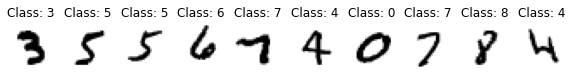

In [104]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [105]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [106]:
def train(epoch, losst, acct,  log_interval=200):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()
        
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.data.item()))
            
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)

    losst.append(avg_loss) 
    acct.append(accuracy*100.)
    
    return model

In [107]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    #print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #val_loss, correct, len(validation_loader.dataset), accuracy))

In [108]:
%%time
epochs = 100

lossv, accv = [], []
losst, acct = [], []
for epoch in range(1, epochs + 1):
    train(epoch, losst, acct)
    validate(lossv, accv)

CPU times: user 3min 18s, sys: 17.7 s, total: 3min 36s
Wall time: 3min 24s


Text(0.5, 1.0, 'validation accuracy')

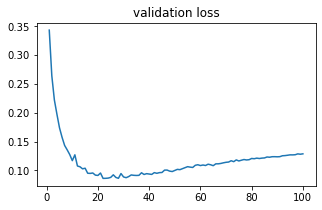

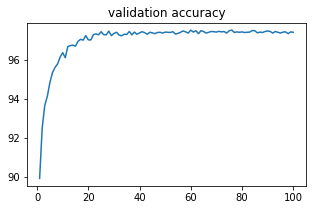

In [109]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

Text(0.5, 1.0, 'train accuracy')

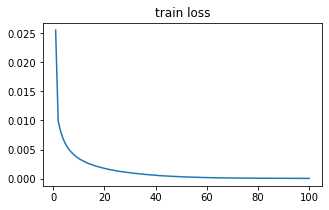

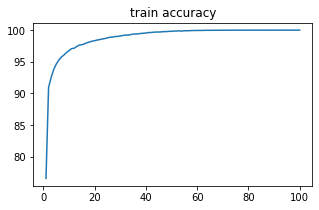

In [110]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), losst)
plt.title('train loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), acct)
plt.title('train accuracy')

In [111]:
def minus_100(n):
    return 100-n

acct_before = list(map(minus_100, acct))
accv_before = list(map(minus_100, accv))
losst_before = losst
lossv_before = lossv

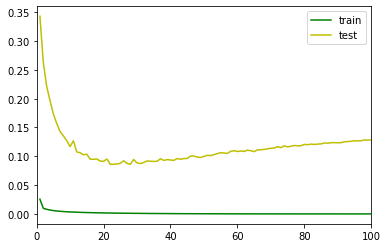

In [112]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.xlim(0, 100)

ax.plot(np.arange(1,epochs+1), losst_before, label='train',color="g")
ax.plot(np.arange(1,epochs+1), lossv_before, label='test',color="y")
plt.legend()
plt.show()

# Early Stop

In [113]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [114]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [115]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


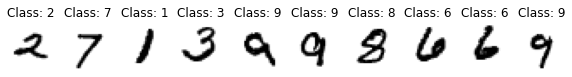

In [116]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [117]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [118]:
def train(epoch, losst, acct,  log_interval=200):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()
        
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.data.item()))
            
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)

    losst.append(avg_loss) 
    acct.append(accuracy*100.)
    
    return model

In [119]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    #print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #val_loss, correct, len(validation_loader.dataset), accuracy))

In [120]:
%%time
epochs = 100
num_allow_continue = 2

num_epoch_result = 0
num_continue_worse = 0
max_continue_worse = 0

# 早期終了を使ったモデルの学習結果
model_final = 0

last_lossv = 100

lossv, accv = [], []
losst, acct = [], []
for epoch in range(1, epochs + 1):
    model_now = train(epoch, losst, acct)
    validate(lossv, accv)
    num_epoch_result = num_epoch_result+1
    
    # 悪化した場合の検出
    if(last_lossv < lossv[epoch-1]):
        num_continue_worse = num_continue_worse + 1
    else:
        num_continue_worse = 0
        model_final = model_now
        
    if(max_continue_worse < num_continue_worse):
        max_continue_worse = num_continue_worse
        
    if(num_continue_worse > num_allow_continue):
        break
    
    last_lossv = lossv[epoch-1]
    
print("回数：{num}".format(num = max_continue_worse))
print(len(accv))
print(num_epoch_result)

0.11446553207680987
0.09542899930473274
0.09657882192780594
0.08825332240650922
0.0850781928232299
0.0873258565925629
0.08897341173240757
回数：3
26
26
CPU times: user 52.8 s, sys: 5.1 s, total: 57.9 s
Wall time: 54.8 s


In [25]:
%%time
epochs = 100
num_allow_continue = 2

num_epoch_result = 0
num_continue_worse = 0
max_continue_worse = 0

# 早期終了を使ったモデルの学習結果
model_final = 0

last_accv = 0

lossv, accv = [], []
losst, acct = [], []
for epoch in range(1, epochs + 1):
    model_now = train(epoch, losst, acct)
    validate(lossv, accv)
    num_epoch_result = num_epoch_result+1
    
    # 悪化した場合の検出
    if(last_accv > accv[epoch-1]):
        num_continue_worse = num_continue_worse + 1
    else:
        num_continue_worse = 0
        model_final = model_now
        
    if(max_continue_worse < num_continue_worse):
        max_continue_worse = num_continue_worse
        
    if(num_continue_worse > num_allow_continue):
        break
    
    last_accv = accv[epoch-1]
    
print("回数：{num}".format(num = max_continue_worse))
print(len(accv))
print(num_epoch_result)

回数：2
100
100
CPU times: user 3min 20s, sys: 17.3 s, total: 3min 37s
Wall time: 3min 26s


In [121]:
len(lossv[0:len(lossv)-2])

24

Text(0.5, 1.0, 'validation accuracy')

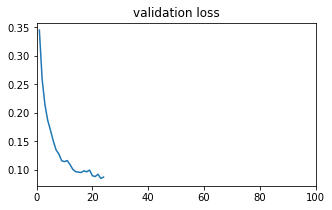

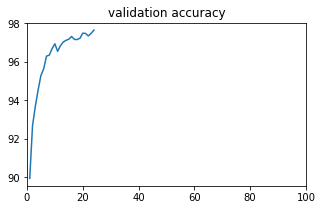

In [122]:
plt.figure(figsize=(5,3))
plt.xlim(0, 100)
#plt.ylim(0.09, 0.11)
plt.plot(np.arange(1,num_epoch_result-1), lossv[0:len(lossv)-2])
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.xlim(0, 100)
#plt.ylim(96, 98)
plt.plot(np.arange(1,num_epoch_result-1), accv[0:len(lossv)-2])
plt.title('validation accuracy')

Text(0.5, 1.0, 'train accuracy')

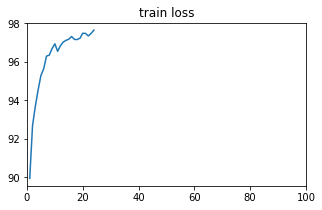

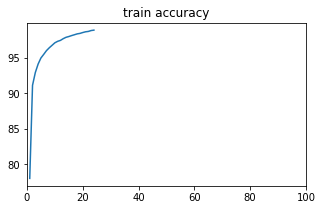

In [123]:
plt.figure(figsize=(5,3))
plt.xlim(0, 100)
# plt.ylim(0.09, 0.11)
plt.plot(np.arange(1,num_epoch_result-1), accv[0:len(lossv)-2])
plt.title('train loss')

plt.figure(figsize=(5,3))
plt.xlim(0, 100)
# plt.ylim(96, 98)
plt.plot(np.arange(1,num_epoch_result-1), acct[0:len(lossv)-2])
plt.title('train accuracy')

In [124]:
def minus_100(n):
    return 100-n

epoch_early = num_epoch_result
acct_early = list(map(minus_100, acct))
accv_early = list(map(minus_100, accv))
losst_early = losst
lossv_early = lossv

Text(0.5, 1.0, 'validation accuracy')

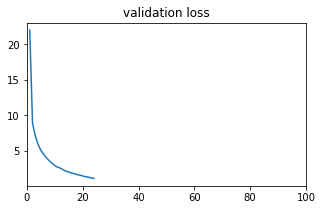

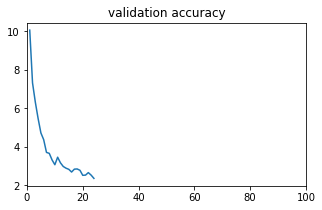

In [125]:
plt.figure(figsize=(5,3))
plt.xlim(0, 100)
plt.plot(np.arange(1,epoch_early-1), acct_early[0:len(lossv)-2])
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.xlim(0, 100)
plt.plot(np.arange(1,epoch_early-1), accv_early[0:len(lossv)-2])
plt.title('validation accuracy')

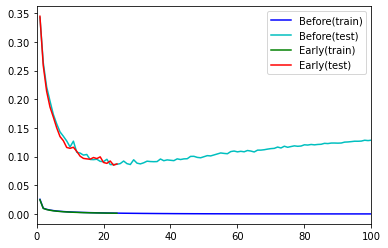

In [126]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.xlim(0, 100)

ax.plot(np.arange(1,epochs+1), losst_before, label='Before(train)',color="b")
ax.plot(np.arange(1,epochs+1), lossv_before, label='Before(test)',color="c")
ax.plot(np.arange(1,epoch_early-1), losst_early[0:len(lossv)-2], label='Early(train)',color="g")
ax.plot(np.arange(1,epoch_early-1), lossv_early[0:len(lossv)-2], label='Early(test)',color="r")
plt.legend()
plt.show()

# Label Smoothing

In [153]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
#print('Using PyTorch version:', torch.__version__, ' Device:', device)

In [154]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

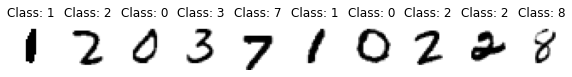

In [155]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [156]:
def linear_combination(x, y, epsilon):
    return (1 - epsilon) * x + epsilon * y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.01, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(nll, loss/n, self.epsilon)

In [157]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        # self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        # self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        # x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        # x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = LabelSmoothingCrossEntropy()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [158]:
def train(epoch, losst, acct,  log_interval=200):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()
        
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.data.item()))
            
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)

    losst.append(avg_loss) 
    acct.append(accuracy*100.)
    #print(avg_loss)
    #print(accuracy)

In [159]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    #print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #val_loss, correct, len(validation_loader.dataset), accuracy))

In [160]:
%%time
epochs = 100

lossv, accv = [], []
losst, acct = [], []
for epoch in range(1, epochs + 1):
    train(epoch, losst, acct)
    validate(lossv, accv)

CPU times: user 3min 29s, sys: 16.9 s, total: 3min 46s
Wall time: 3min 35s


In [161]:
epochs

100

Text(0.5, 1.0, 'validation accuracy')

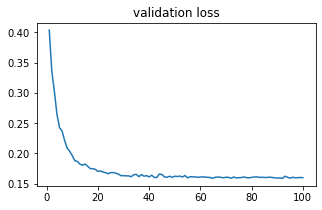

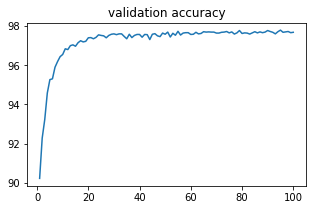

In [162]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

Text(0.5, 1.0, 'train accuracy')

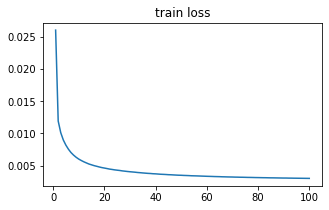

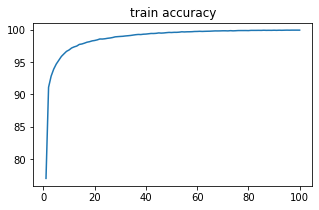

In [163]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), losst)
plt.title('train loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), acct)
plt.title('train accuracy')

In [164]:
def minus_100(n):
    return 100-n

acct_smoothing = list(map(minus_100, acct))
accv_smoothing = list(map(minus_100, accv))
losst_smoothing = losst
lossv_smoothing = lossv

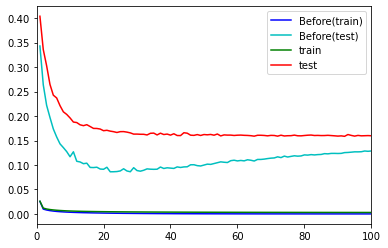

In [165]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.xlim(0, 100)

ax.plot(np.arange(1,epochs+1), losst_before, label='Before(train)',color="b")
ax.plot(np.arange(1,epochs+1), lossv_before, label='Before(test)',color="c")
ax.plot(np.arange(1,epochs+1), losst_smoothing, label='train',color="g")
ax.plot(np.arange(1,epochs+1), lossv_smoothing, label='test',color="r")
plt.legend()
plt.show()

# Dropout

In [140]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [141]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [142]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


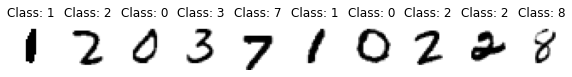

In [143]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [144]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [145]:
def train(epoch, losst, acct,  log_interval=200):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()
        
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.data.item()))
            
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)

    losst.append(avg_loss) 
    acct.append(accuracy*100.)
    #print(avg_loss)
    #print(accuracy)

In [146]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    #print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #val_loss, correct, len(validation_loader.dataset), accuracy))

In [147]:
%%time
epochs = 100

lossv, accv = [], []
losst, acct = [], []
for epoch in range(1, epochs + 1):
    train(epoch, losst, acct)
    validate(lossv, accv)

CPU times: user 3min 26s, sys: 18.1 s, total: 3min 44s
Wall time: 3min 32s


Text(0.5, 1.0, 'validation accuracy')

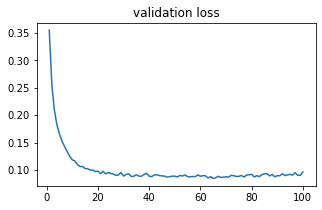

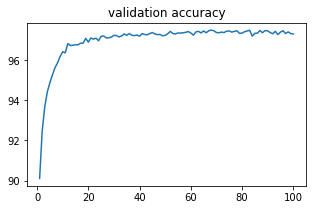

In [148]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

Text(0.5, 1.0, 'train accuracy')

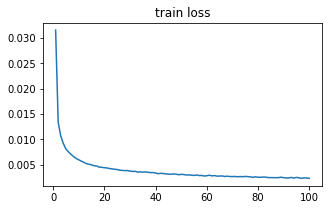

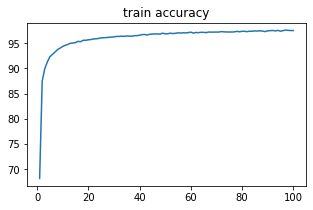

In [149]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), losst)
plt.title('train loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), acct)
plt.title('train accuracy')

In [150]:
def minus_100(n):
    return 100-n

acct_flooding = list(map(minus_100, acct))
accv_flooding = list(map(minus_100, accv))
losst_flooding = losst
lossv_flooding = lossv

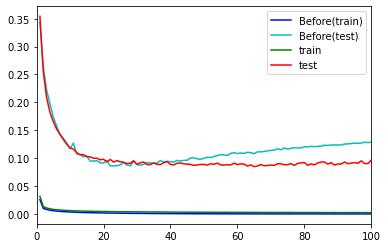

In [151]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.xlim(0, 100)

ax.plot(np.arange(1,epochs+1), losst_before, label='Before(train)',color="b")
ax.plot(np.arange(1,epochs+1), lossv_before, label='Before(test)',color="c")
ax.plot(np.arange(1,epochs+1), losst_flooding, label='train',color="g")
ax.plot(np.arange(1,epochs+1), lossv_flooding, label='test',color="r")
plt.legend()
plt.show()

# All Result Except Early

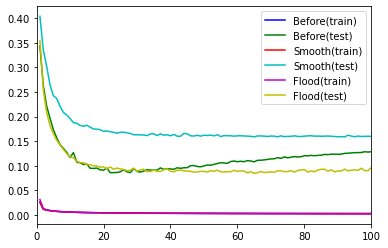

In [166]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.xlim(0, 100)

ax.plot(np.arange(1,epochs+1), losst_smoothing, label='Before(train)',color="b")
ax.plot(np.arange(1,epochs+1), lossv_before, label='Before(test)',color="g")
ax.plot(np.arange(1,epochs+1), losst_smoothing, label='Smooth(train)',color="r")
ax.plot(np.arange(1,epochs+1), lossv_smoothing, label='Smooth(test)',color="c")
ax.plot(np.arange(1,epochs+1), losst_flooding, label='Flood(train)',color="m")
ax.plot(np.arange(1,epochs+1), lossv_flooding, label='Flood(test)',color="y")
plt.legend()
plt.show()